In [1]:
import sys
sys.path.append('..')
import numpy as np 


In [3]:
# Loading my modules
from plotting_tools.plotter import plotter, cross_section_plotter
from physics_informed_vector_fields.current_carrying_coil import field_around_current_carrying_coil
from plotting_tools.field_comparison import differencer

from plotting_tools.sample_field import sample_field

from GP_Implementation.Kernel import sample_vector_field

In [ ]:
outputs_wire = field_around_current_carrying_coil(100000000, resolution=30)
#test_outputs = sample_vector_field(kernel_func='divergence_free_kernel')
plotter(outputs_wire, 
        title = 'B fields around current carrying wire')

In [5]:
# unpack outputs
x, y, z = outputs_wire[0], outputs_wire[1], outputs_wire[2]
u, v, w = outputs_wire[3], outputs_wire[4], outputs_wire[5]

In [6]:
field_magnitude = np.zeros_like(v)
field_magnitude = np.sqrt(u**2 + v**2 +w**2)

In [7]:
u_norm, v_norm, w_norm = u/field_magnitude, v/field_magnitude, w/field_magnitude 

In [ ]:
plotter([x, y, z, u_norm, v_norm, w_norm],
        title = 'B fields around current carrying wire')

In [9]:
import numpy as np

def compute_jacobian(field, dx):
    """
    field: shape (Nx, Ny, Nz, 3) — 3D vector field
    dx:    float or 3-tuple of spacing(s)
    
    Returns
    -------
    jacobian: shape (Nx, Ny, Nz, 3, 3)
       jacobian[i, j, k] is the 3×3 matrix of partial derivatives
       at (i, j, k). Rows are partial wrt x, y, z; columns are B_x, B_y, B_z.
    """
    grads = [np.gradient(field[..., i], *( [dx]*3 ), edge_order=1)
             for i in range(3)]  # each grads[i] is a list [∂/∂x of B_i, ∂/∂y of B_i, ∂/∂z of B_i]

    # Stack into shape: (3, 3, Nx, Ny, Nz)
    jacobian = np.array(grads)
    # Transpose to shape: (Nx, Ny, Nz, 3, 3)
    jacobian = np.transpose(jacobian, (2, 3, 4, 0, 1))

    return jacobian

def distortion_by_axis(jacobian):
    """
    Computes the per-axis 'distortion'. For each voxel, we look at the 3×3 
    Jacobian matrix and sum squares across each row, giving a shape (Nx, Ny, Nz, 3).

    If the Jacobian at a point is:
       [[∂Bx/∂x, ∂By/∂x, ∂Bz/∂x],
        [∂Bx/∂y, ∂By/∂y, ∂Bz/∂y],
        [∂Bx/∂z, ∂By/∂z, ∂Bz/∂z]],
    then for row i, we do:
       distortion[i] = sqrt( (∂Bx/∂i)^2 + (∂By/∂i)^2 + (∂Bz/∂i)^2 ).

    Returns
    -------
    dist: shape (Nx, Ny, Nz, 3)
          dist[...,0] is the x-distortion, 
          dist[...,1] is the y-distortion, 
          dist[...,2] is the z-distortion.
    """
    # Sum squares across columns (the last axis = -1)
    rowwise_sums = np.sum(jacobian**2, axis=-1)  
    # Take square root to get distortion
    dist = rowwise_sums
    return dist


In [10]:
field = np.stack([u_norm, v_norm, w_norm], axis=-1)  # shape: (Nx, Ny, Nz, 3)
matrix = compute_jacobian(field, dx=1)
matrix.shape

(30, 30, 30, 3, 3)

In [11]:
scalar_function = distortion_by_axis(matrix)
scalar_function.shape

(30, 30, 30, 3)

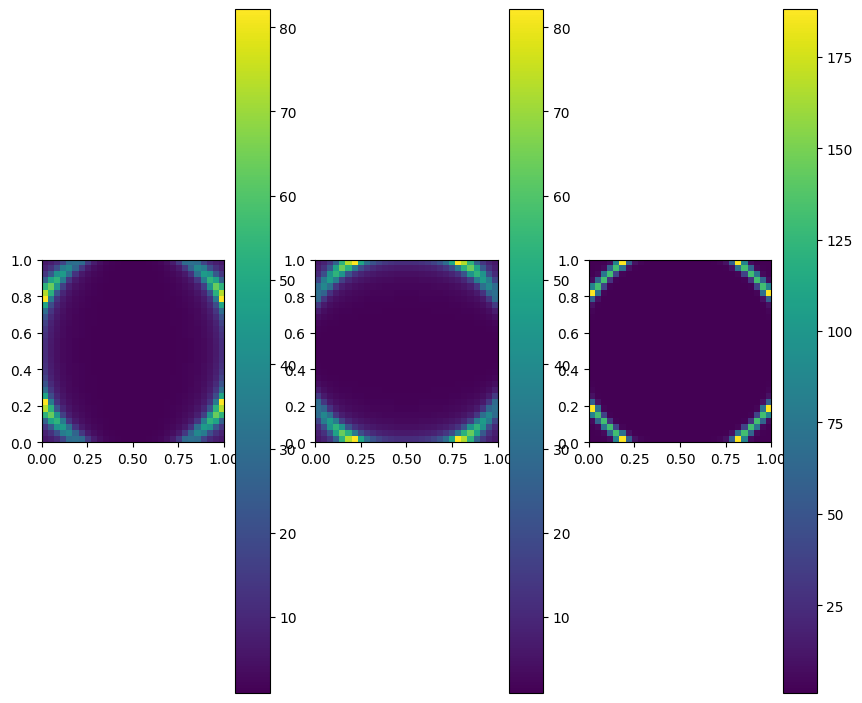

In [12]:
import numpy as np
import matplotlib.pyplot as plt

# Assume: scalar_function.shape = (Nx, Ny, Nz, 3)
# Adjust and pick a slice
scalar_function = scalar_function + 0.01
scalar_function = scalar_function 
z_index = scalar_function.shape[2] // 2

slice_2d_x_dist = scalar_function[:, :, z_index, 0] / np.min(scalar_function[:, :, z_index, 0])
slice_2d_y_dist = scalar_function[:, :, z_index, 1] / np.min(scalar_function[:, :, z_index, 1])
slice_2d_z_dist = scalar_function[:, :, z_index, 2] / np.min(scalar_function[:, :, z_index, 2])

fig, axes = plt.subplots(1, 3, figsize=(10, 15))

# Plot each slice and store the result in imX
im0 = axes[0].imshow(slice_2d_x_dist.T, origin='lower', cmap='viridis', extent=[0, 1, 0, 1])
im1 = axes[1].imshow(slice_2d_y_dist.T, origin='lower', cmap='viridis', extent=[0, 1, 0, 1])
im2 = axes[2].imshow(slice_2d_z_dist.T, origin='lower', cmap='viridis', extent=[0, 1, 0, 1])

fig.colorbar(im0, ax=axes[0], orientation='vertical')
fig.colorbar(im1, ax=axes[1], orientation='vertical')
fig.colorbar(im2, ax=axes[2], orientation='vertical')

plt.show()


In [13]:
np.max(slice_2d_x_dist)

np.float64(82.14146876333642)

In [14]:
from scipy.interpolate import RegularGridInterpolator

# Define physical grid — adjust to your domain
x = np.linspace(-1/2, 1/2, 30)
y = np.linspace(-1/2, 1/2, 30)
z = np.linspace(-1/2, 1/2, 30)

scalar_function_x = scalar_function[:, :, :,0] / np.min(scalar_function[:, :, :,0])
scalar_function_y = scalar_function[:, :, :,1] / np.min(scalar_function[:, :, :,1])
scalar_function_z = scalar_function[:, :, :,2] / np.min(scalar_function[:, :, :,2])

interp_variation_x = RegularGridInterpolator((x, y, z), scalar_function_x, bounds_error=False, fill_value=None)
interp_variation_y = RegularGridInterpolator((x, y, z), scalar_function_y, bounds_error=False, fill_value=None)
interp_variation_z = RegularGridInterpolator((x, y, z), scalar_function_z, bounds_error=False, fill_value=None)



In [15]:
import numpy as np
from functools import lru_cache
from scipy.integrate import quad

@lru_cache(maxsize=None)
def warp_coordinate(
    coords_3d,
    interp_alpha = [interp_variation_x, interp_variation_y, interp_variation_z],
    axis_points=50
):
    """
    Warp a single 3D point using line integrals along each axis from the origin.

    Args:
        coords_3d: (3,) array-like
        interp_alpha: list of 3 interpolator functions
                      [interp_variation_x, interp_variation_y, interp_variation_z]
        axis_points: number of steps for integration (not currently used by quad, 
                     but you could pass "limit=axis_points" to quad if you want).

    Returns:
        x_prime: (3,) warped coordinate
    """
    x = np.asarray(coords_3d, dtype=float)
    x_prime = np.zeros_like(x)
    val_multiplier = 1
    for i in range(3):
        # Integrate along axis i from 0 to x[i], holding other coords fixed
        def integrand(t):
            # create a copy of x so we can vary only the i-th coordinate
            pt = np.zeros_like(x)  # <-- this is the fix: start from the origin
            pt[i] = t              # vary only the i-th axis
            return float(interp_alpha[i](pt)[0])

        # If x[i] < 0, flip integration bounds
        start, end = 0, x[i]
        # if x[i] < 0:
        #     start, end = x[i], 0
        #     val_multiplier = -1
        val, _ = quad(integrand, start, end)  # you can add limit=axis_points if needed
        x_prime[i] = val 
    
    return x_prime



In [17]:
pt = [0.001, -1, 2]
warped_pt = warp_coordinate(tuple(pt))
print("Original:", pt)
print("Warped:", warped_pt)


Original: [0.001, -1, 2]
Warped: [ 1.00000000e-03 -2.40741131e+01  2.00076436e+00]


In [18]:
def divergence_free_kernel(x1:np.array, x2:np.array, sigma_f:float =1, l:float=1)->np.ndarray:
    '''
    Should be a divergence free vector field which you get from here. There surely arent that 
    many of these, so this will hopefully quickly look like a magnetic field. 

    formula 2.48
    '''
    
    # if np.any((np.sqrt(x1[0]**2+x1[1]**2) < 0.2) and (np.sqrt(x2[0]**2+x2[1]**2) < 0.2)):
    #     l = 0.2
    # elif (np.sqrt(x1[0]**2+x1[1]**2) < 0.2) or (np.sqrt(x2[0]**2+x2[1]**2) < 0.2):
    #     return np.zeros((3,3))
    # else:
    #     l = 1
    diff = x1 - x2
    # def some distance measure
    r2 = np.dot(diff, diff)
    term1 = (2 - r2 / l**2) * np.eye(len(x1))
    term2 = np.outer(diff, diff) / l**2
    scaling = np.exp(- r2 / (2 * l**2)) * (sigma_f / l)**2
    K = (term1 + term2) * scaling
    return K


In [19]:
from tqdm import tqdm

In [20]:
def updated_vector_field(inputs:list[np.ndarray],
                         grid_x: np.ndarray, grid_y: np.ndarray, grid_z: np.ndarray,
                         sigma_f = None, l = None,
                         random_seed: int = 1, 
                         noise:float = 1e-6):
    """
    Compute the GP-posterior vector field given noisy vector observations at a few points.
    returns a 3D vector field evaluated over the entire grid, conditioned on known field measurements.
    """
    sampled_points_x, sampled_points_y, sampled_points_z = inputs[0], inputs[1], inputs[2]
    sampled_fields_x, sampled_fields_y, sampled_fields_z = inputs[3], inputs[4], inputs[5]
    np.random.seed(random_seed)

    # Choose kernel

    function_chosen = divergence_free_kernel  

    # this allows us to loop over these points
    points = np.vstack([grid_x.flatten(), grid_y.flatten(), grid_z.flatten()]).T               # (N, 3)
    points_sampled = np.vstack([sampled_points_x.flatten(), sampled_points_y.flatten(), sampled_points_z.flatten()]).T  # (M, 3)
    fields_sampled = np.vstack([sampled_fields_x.flatten(), sampled_fields_y.flatten(), sampled_fields_z.flatten()]).T  # (M, 3)

    N = points.shape[0]           # number of grid points
    M = points_sampled.shape[0]   # number of observations
    D = 3                         # vector field dimensionality

    # Allocate covariance matrices
    K_x_x = np.zeros((M * D, M * D))        # covariance between sampled points
    K_xstar_x = np.zeros((N * D, M * D))    # covariance between grid and sampled
    K_xstar_xstar = np.zeros((N * D, N * D))  # covariance between grid points
    # also our observations vector 
    y = np.zeros(M * D)

    # Build K_x_x
    for i in tqdm(range(M)):#, desc="Loop 0", position=0, leave=True):
        for j in range(M):
            x1_transformed = warp_coordinate(tuple(points_sampled[i]))
            x2_transformed = warp_coordinate(tuple(points_sampled[j]))
            K_ij = function_chosen(x1_transformed, x2_transformed, sigma_f=sigma_f, l=l)  # (3x3)
            K_x_x[i*D:(i+1)*D, j*D:(j+1)*D] = K_ij
    print('matrix 1 populated')

    # Build K_xstar_x
    for i in tqdm(range(N)):
        for j in range(M):
            x1_transformed = warp_coordinate(tuple(points[i]))
            x2_transformed = warp_coordinate(tuple(points_sampled[j]))
            K_ij = function_chosen(points[i], points_sampled[j], sigma_f=sigma_f, l=l)  # (3x3)
            K_xstar_x[i*D:(i+1)*D, j*D:(j+1)*D] = K_ij
    print('matrix 2 populated')

    # Build K_xstar_xstar
    for i in tqdm(range(N)):
        for j in range(N):
            x1_transformed = warp_coordinate(tuple(points[i]))
            x2_transformed = warp_coordinate(tuple(points[j]))
            K_ij = function_chosen(points[i], points[j], sigma_f=sigma_f, l=l)  # (3x3)
            K_xstar_xstar[i*D:(i+1)*D, j*D:(j+1)*D] = K_ij
    print('matrix 3 populated')

    # Build y
    for i in range(M):
        y[i*D:(i+1)*D] = fields_sampled[i]  # (3x,)?
    print('matrix 4 populated')

    # GP posterior mean and cov sampled
    K_x_x = K_x_x + noise * np.eye(M * D)
    print('initialising solver')
    posterior_mean = K_xstar_x @ np.linalg.solve(K_x_x, y)
    posterior_covar = K_xstar_xstar - K_xstar_x @ np.linalg.solve(K_x_x, K_xstar_x.T)
    # sample = np.random.multivariate_normal(posterior_mean, posterior_covar)

    # Reshape into 3D vector field
    field_vectors = posterior_mean.reshape(N, D)
    U = field_vectors[:, 0].reshape(grid_x.shape)
    V = field_vectors[:, 1].reshape(grid_y.shape)
    W = field_vectors[:, 2].reshape(grid_z.shape)

    return grid_x, grid_y, grid_z, U, V, W

In [21]:
sparse_outputs_wire = field_around_current_carrying_coil(100000000, resolution=10)

sampled_outputs_wire = sample_field(sparse_outputs_wire, n_samples=250, random_seed=1)


In [22]:
plotter(sampled_outputs_wire, 
        title = 'Points given to our GP Regressor for current carrying wire')

In [40]:
outputs_coil_div_free= updated_vector_field(
    sampled_outputs_wire, 
    sparse_outputs_wire[0], sparse_outputs_wire[1], sparse_outputs_wire[2], 
    sigma_f= 0.00008, l = 0.26)

100%|██████████| 250/250 [00:00<00:00, 273.16it/s]


matrix 1 populated


100%|██████████| 1000/1000 [00:03<00:00, 275.65it/s]


matrix 2 populated


100%|██████████| 1000/1000 [00:14<00:00, 68.16it/s]


matrix 3 populated
matrix 4 populated
initialising solver


In [41]:
given_samples_wire = sampled_outputs_wire[0].shape[0]
plotter(outputs_coil_div_free, 
        title = f'Div free output from GP Regression for n = {given_samples_wire} input vectors for current carrying wire')

In [42]:
residuals_wire_div_free, mse_wire_div_free = differencer(outputs_coil_div_free, sparse_outputs_wire)
print(f'MSE for this case of {mse_wire_div_free}')
plotter(residuals_wire_div_free, 
        title = f'Div free regression errors for n = {given_samples_wire} input vectors for current carrying wire')

MSE for this case of 13.427980853951667


In [36]:
# grid search time 
from itertools import product

sigmas = [0.00015, 0.00010, 0.00008, 0.00005, 0.00003, 0.00001]
ls = [0.3, 0.28, 0.26, 0.24, 0.22, 0.2]
for sigma, l in product(sigmas, ls):
    outputs_wire_div_free= updated_vector_field(
        sampled_outputs_wire, 
        sparse_outputs_wire[0], sparse_outputs_wire[1], sparse_outputs_wire[2], 
        sigma_f= sigma, l = l)
    _, mse_wire_div_free = differencer(outputs_wire_div_free, sparse_outputs_wire)
    print(f'for sigma = {sigma}, l = {l}, mse is {mse_wire_div_free}')

100%|██████████| 250/250 [00:00<00:00, 295.42it/s]


matrix 1 populated


100%|██████████| 1000/1000 [00:03<00:00, 309.32it/s]


matrix 2 populated


100%|██████████| 1000/1000 [00:14<00:00, 70.78it/s]


matrix 3 populated
matrix 4 populated
initialising solver
for sigma = 0.00015, l = 0.3, mse is 55.34627084437602


100%|██████████| 250/250 [00:00<00:00, 291.57it/s]


matrix 1 populated


100%|██████████| 1000/1000 [00:03<00:00, 286.34it/s]


matrix 2 populated


100%|██████████| 1000/1000 [00:14<00:00, 69.44it/s]


matrix 3 populated
matrix 4 populated
initialising solver
for sigma = 0.00015, l = 0.28, mse is 51.75689089176574


100%|██████████| 250/250 [00:01<00:00, 240.20it/s]


matrix 1 populated


100%|██████████| 1000/1000 [00:04<00:00, 248.33it/s]


matrix 2 populated


100%|██████████| 1000/1000 [00:14<00:00, 68.35it/s]


matrix 3 populated
matrix 4 populated
initialising solver
for sigma = 0.00015, l = 0.26, mse is 47.96930236950936


100%|██████████| 250/250 [00:00<00:00, 262.25it/s]


matrix 1 populated


100%|██████████| 1000/1000 [00:03<00:00, 282.85it/s]


matrix 2 populated


100%|██████████| 1000/1000 [00:15<00:00, 65.06it/s]


matrix 3 populated
matrix 4 populated
initialising solver
for sigma = 0.00015, l = 0.24, mse is 44.06290908011567


100%|██████████| 250/250 [00:00<00:00, 265.33it/s]


matrix 1 populated


100%|██████████| 1000/1000 [00:03<00:00, 278.44it/s]


matrix 2 populated


100%|██████████| 1000/1000 [00:14<00:00, 68.03it/s]


matrix 3 populated
matrix 4 populated
initialising solver
for sigma = 0.00015, l = 0.22, mse is 40.318890184476864


100%|██████████| 250/250 [00:00<00:00, 270.32it/s]


matrix 1 populated


100%|██████████| 1000/1000 [00:03<00:00, 257.67it/s]


matrix 2 populated


100%|██████████| 1000/1000 [00:15<00:00, 65.98it/s]


matrix 3 populated
matrix 4 populated
initialising solver
for sigma = 0.00015, l = 0.2, mse is 37.54544797127228


100%|██████████| 250/250 [00:00<00:00, 265.59it/s]


matrix 1 populated


100%|██████████| 1000/1000 [00:03<00:00, 295.69it/s]


matrix 2 populated


100%|██████████| 1000/1000 [00:14<00:00, 68.65it/s]


matrix 3 populated
matrix 4 populated
initialising solver
for sigma = 0.0001, l = 0.3, mse is 26.606283162648435


100%|██████████| 250/250 [00:00<00:00, 290.08it/s]


matrix 1 populated


100%|██████████| 1000/1000 [00:03<00:00, 278.67it/s]


matrix 2 populated


100%|██████████| 1000/1000 [00:14<00:00, 68.94it/s]


matrix 3 populated
matrix 4 populated
initialising solver
for sigma = 0.0001, l = 0.28, mse is 24.304077840950903


100%|██████████| 250/250 [00:00<00:00, 269.75it/s]


matrix 1 populated


100%|██████████| 1000/1000 [00:03<00:00, 278.34it/s]


matrix 2 populated


100%|██████████| 1000/1000 [00:14<00:00, 69.34it/s]


matrix 3 populated
matrix 4 populated
initialising solver
for sigma = 0.0001, l = 0.26, mse is 22.132175698787467


100%|██████████| 250/250 [00:00<00:00, 258.36it/s]


matrix 1 populated


100%|██████████| 1000/1000 [00:03<00:00, 286.20it/s]


matrix 2 populated


100%|██████████| 1000/1000 [00:14<00:00, 68.80it/s]


matrix 3 populated
matrix 4 populated
initialising solver
for sigma = 0.0001, l = 0.24, mse is 20.416481311965555


100%|██████████| 250/250 [00:00<00:00, 278.13it/s]


matrix 1 populated


100%|██████████| 1000/1000 [00:03<00:00, 278.80it/s]


matrix 2 populated


100%|██████████| 1000/1000 [00:13<00:00, 72.37it/s]


matrix 3 populated
matrix 4 populated
initialising solver
for sigma = 0.0001, l = 0.22, mse is 19.86605731313414


100%|██████████| 250/250 [00:00<00:00, 283.02it/s]


matrix 1 populated


100%|██████████| 1000/1000 [00:03<00:00, 279.04it/s]


matrix 2 populated


100%|██████████| 1000/1000 [00:14<00:00, 67.67it/s]


matrix 3 populated
matrix 4 populated
initialising solver
for sigma = 0.0001, l = 0.2, mse is 21.071262897178656


100%|██████████| 250/250 [00:00<00:00, 297.71it/s]


matrix 1 populated


100%|██████████| 1000/1000 [00:03<00:00, 293.56it/s]


matrix 2 populated


100%|██████████| 1000/1000 [00:14<00:00, 69.82it/s]


matrix 3 populated
matrix 4 populated
initialising solver
for sigma = 8e-05, l = 0.3, mse is 14.409822197972312


100%|██████████| 250/250 [00:01<00:00, 245.99it/s]


matrix 1 populated


100%|██████████| 1000/1000 [00:03<00:00, 270.80it/s]


matrix 2 populated


100%|██████████| 1000/1000 [00:14<00:00, 68.99it/s]


matrix 3 populated
matrix 4 populated
initialising solver
for sigma = 8e-05, l = 0.28, mse is 13.557746694993758


100%|██████████| 250/250 [00:01<00:00, 235.73it/s]


matrix 1 populated


100%|██████████| 1000/1000 [00:03<00:00, 277.88it/s]


matrix 2 populated


100%|██████████| 1000/1000 [00:14<00:00, 69.68it/s]


matrix 3 populated
matrix 4 populated
initialising solver
for sigma = 8e-05, l = 0.26, mse is 13.427980853951667


100%|██████████| 250/250 [00:00<00:00, 278.76it/s]


matrix 1 populated


100%|██████████| 1000/1000 [00:03<00:00, 289.34it/s]


matrix 2 populated


100%|██████████| 1000/1000 [00:14<00:00, 67.36it/s]


matrix 3 populated
matrix 4 populated
initialising solver
for sigma = 8e-05, l = 0.24, mse is 14.466255849457061


100%|██████████| 250/250 [00:00<00:00, 284.34it/s]


matrix 1 populated


100%|██████████| 1000/1000 [00:03<00:00, 297.42it/s]


matrix 2 populated


100%|██████████| 1000/1000 [00:14<00:00, 68.33it/s]


matrix 3 populated
matrix 4 populated
initialising solver
for sigma = 8e-05, l = 0.22, mse is 16.921903141573633


100%|██████████| 250/250 [00:01<00:00, 239.76it/s]


matrix 1 populated


100%|██████████| 1000/1000 [00:04<00:00, 232.25it/s]


matrix 2 populated


100%|██████████| 1000/1000 [00:15<00:00, 66.00it/s]


matrix 3 populated
matrix 4 populated
initialising solver
for sigma = 8e-05, l = 0.2, mse is 20.478389079014274


100%|██████████| 250/250 [00:00<00:00, 258.96it/s]


matrix 1 populated


100%|██████████| 1000/1000 [00:03<00:00, 290.20it/s]


matrix 2 populated


100%|██████████| 1000/1000 [00:13<00:00, 71.66it/s]


matrix 3 populated
matrix 4 populated
initialising solver
for sigma = 5e-05, l = 0.3, mse is 22.517056101245753


100%|██████████| 250/250 [00:00<00:00, 286.45it/s]


matrix 1 populated


100%|██████████| 1000/1000 [00:03<00:00, 287.16it/s]


matrix 2 populated


100%|██████████| 1000/1000 [00:14<00:00, 70.64it/s]


matrix 3 populated
matrix 4 populated
initialising solver
for sigma = 5e-05, l = 0.28, mse is 24.149332206968904


100%|██████████| 250/250 [00:00<00:00, 266.02it/s]


matrix 1 populated


100%|██████████| 1000/1000 [00:03<00:00, 278.21it/s]


matrix 2 populated


100%|██████████| 1000/1000 [00:14<00:00, 69.76it/s]


matrix 3 populated
matrix 4 populated
initialising solver
for sigma = 5e-05, l = 0.26, mse is 26.140904283792512


100%|██████████| 250/250 [00:00<00:00, 285.93it/s]


matrix 1 populated


100%|██████████| 1000/1000 [00:03<00:00, 265.54it/s]


matrix 2 populated


100%|██████████| 1000/1000 [00:14<00:00, 68.00it/s]


matrix 3 populated
matrix 4 populated
initialising solver
for sigma = 5e-05, l = 0.24, mse is 28.49140312911329


100%|██████████| 250/250 [00:01<00:00, 239.30it/s]


matrix 1 populated


100%|██████████| 1000/1000 [00:03<00:00, 261.21it/s]


matrix 2 populated


100%|██████████| 1000/1000 [00:14<00:00, 68.23it/s]


matrix 3 populated
matrix 4 populated
initialising solver
for sigma = 5e-05, l = 0.22, mse is 31.189799811014776


100%|██████████| 250/250 [00:01<00:00, 227.64it/s]


matrix 1 populated


100%|██████████| 1000/1000 [00:03<00:00, 255.04it/s]


matrix 2 populated


100%|██████████| 1000/1000 [00:14<00:00, 68.26it/s]


matrix 3 populated
matrix 4 populated
initialising solver
for sigma = 5e-05, l = 0.2, mse is 34.21193196378833


100%|██████████| 250/250 [00:00<00:00, 250.74it/s]


matrix 1 populated


100%|██████████| 1000/1000 [00:03<00:00, 267.47it/s]


matrix 2 populated


100%|██████████| 1000/1000 [00:14<00:00, 69.10it/s]


matrix 3 populated
matrix 4 populated
initialising solver
for sigma = 3e-05, l = 0.3, mse is 40.49900000895202


100%|██████████| 250/250 [00:00<00:00, 266.37it/s]


matrix 1 populated


100%|██████████| 1000/1000 [00:03<00:00, 284.41it/s]


matrix 2 populated


100%|██████████| 1000/1000 [00:14<00:00, 67.24it/s]


matrix 3 populated
matrix 4 populated
initialising solver
for sigma = 3e-05, l = 0.28, mse is 41.39692493100639


100%|██████████| 250/250 [00:01<00:00, 227.81it/s]


matrix 1 populated


100%|██████████| 1000/1000 [00:03<00:00, 252.41it/s]


matrix 2 populated


100%|██████████| 1000/1000 [00:14<00:00, 69.44it/s]


matrix 3 populated
matrix 4 populated
initialising solver
for sigma = 3e-05, l = 0.26, mse is 42.46148341594242


100%|██████████| 250/250 [00:00<00:00, 269.45it/s]


matrix 1 populated


100%|██████████| 1000/1000 [00:03<00:00, 268.28it/s]


matrix 2 populated


100%|██████████| 1000/1000 [00:14<00:00, 68.74it/s]


matrix 3 populated
matrix 4 populated
initialising solver
for sigma = 3e-05, l = 0.24, mse is 43.682817829993716


100%|██████████| 250/250 [00:01<00:00, 209.72it/s]


matrix 1 populated


100%|██████████| 1000/1000 [00:03<00:00, 287.04it/s]


matrix 2 populated


100%|██████████| 1000/1000 [00:14<00:00, 68.67it/s]


matrix 3 populated
matrix 4 populated
initialising solver
for sigma = 3e-05, l = 0.22, mse is 45.04289726897476


100%|██████████| 250/250 [00:01<00:00, 241.36it/s]


matrix 1 populated


100%|██████████| 1000/1000 [00:03<00:00, 258.61it/s]


matrix 2 populated


100%|██████████| 1000/1000 [00:14<00:00, 70.87it/s]


matrix 3 populated
matrix 4 populated
initialising solver
for sigma = 3e-05, l = 0.2, mse is 46.514519179801795


100%|██████████| 250/250 [00:00<00:00, 290.87it/s]


matrix 1 populated


100%|██████████| 1000/1000 [00:03<00:00, 279.82it/s]


matrix 2 populated


100%|██████████| 1000/1000 [00:14<00:00, 70.64it/s]


matrix 3 populated
matrix 4 populated
initialising solver
for sigma = 1e-05, l = 0.3, mse is 54.29099973719072


100%|██████████| 250/250 [00:00<00:00, 279.43it/s]


matrix 1 populated


100%|██████████| 1000/1000 [00:03<00:00, 259.49it/s]


matrix 2 populated


100%|██████████| 1000/1000 [00:14<00:00, 70.09it/s]


matrix 3 populated
matrix 4 populated
initialising solver
for sigma = 1e-05, l = 0.28, mse is 54.42100890065177


100%|██████████| 250/250 [00:01<00:00, 237.41it/s]


matrix 1 populated


100%|██████████| 1000/1000 [00:03<00:00, 256.15it/s]


matrix 2 populated


100%|██████████| 1000/1000 [00:14<00:00, 66.99it/s]


matrix 3 populated
matrix 4 populated
initialising solver
for sigma = 1e-05, l = 0.26, mse is 54.57304878510593


100%|██████████| 250/250 [00:00<00:00, 301.38it/s]


matrix 1 populated


100%|██████████| 1000/1000 [00:03<00:00, 276.47it/s]


matrix 2 populated


100%|██████████| 1000/1000 [00:14<00:00, 69.00it/s]


matrix 3 populated
matrix 4 populated
initialising solver
for sigma = 1e-05, l = 0.24, mse is 54.74503885481492


100%|██████████| 250/250 [00:00<00:00, 267.12it/s]


matrix 1 populated


100%|██████████| 1000/1000 [00:03<00:00, 258.80it/s]


matrix 2 populated


100%|██████████| 1000/1000 [00:15<00:00, 65.82it/s]


matrix 3 populated
matrix 4 populated
initialising solver
for sigma = 1e-05, l = 0.22, mse is 54.93347791325675


100%|██████████| 250/250 [00:01<00:00, 243.88it/s]


matrix 1 populated


100%|██████████| 1000/1000 [00:03<00:00, 250.08it/s]


matrix 2 populated


100%|██████████| 1000/1000 [00:15<00:00, 65.26it/s]


matrix 3 populated
matrix 4 populated
initialising solver
for sigma = 1e-05, l = 0.2, mse is 55.13336566573192


In [25]:
values = np.linspace(0, 0.5, 50)
transformed_values = [warp_coordinate(tuple([val, 0, 0]))[0] for val in values]

C:\Users\ellinghh\AppData\Local\Temp\ipykernel_12112\1893303034.py:40: IntegrationWarning:

The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.

C:\Users\ellinghh\AppData\Local\Temp\ipykernel_12112\1893303034.py:40: IntegrationWarning:

The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.



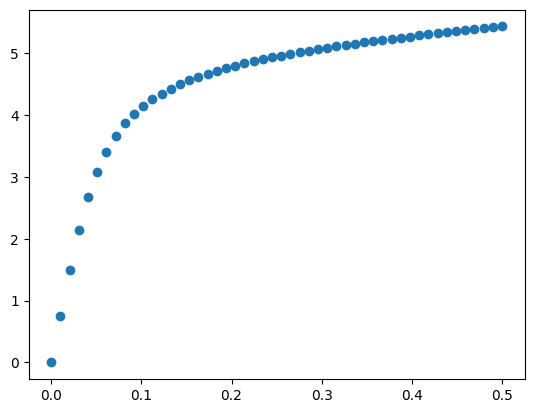

In [26]:
plt.scatter(values, transformed_values)

In [27]:
transformed_values

[np.float64(0.0),
 np.float64(0.748162069375404),
 np.float64(1.4905613267636053),
 np.float64(2.141751623458059),
 np.float64(2.6732746586723604),
 np.float64(3.085130401849511),
 np.float64(3.4039137645117465),
 np.float64(3.6642455855019356),
 np.float64(3.86627175993901),
 np.float64(4.0160921979974855),
 np.float64(4.14365796205216),
 np.float64(4.252996062804096),
 np.float64(4.344254773075591),
 np.float64(4.4238488141052565),
 np.float64(4.495196143596959),
 np.float64(4.558296774099982),
 np.float64(4.614358139544224),
 np.float64(4.665929783480108),
 np.float64(4.713093910847796),
 np.float64(4.756003646458214),
 np.float64(4.795988181438079),
 np.float64(4.833355069496965),
 np.float64(4.86810467810352),
 np.float64(4.9007394496016925),
 np.float64(4.931698350726382),
 np.float64(4.9609815028399575),
 np.float64(4.98870986699059),
 np.float64(5.015260915027901),
 np.float64(5.040681431326173),
 np.float64(5.0649780258331845),
 np.float64(5.088389491328271),
 np.float64(5.110